# models for opcode frequency

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import json
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from utils.main import get_best_thresholds

2025-07-12 11:26:24.771885: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Const

In [3]:
PATH = Path.cwd().parents[1]
DATA_PATH = os.path.join(PATH, 'data/processed')
MODEL_PATH = os.path.join(PATH, 'models')

In [4]:
with open(os.path.join(DATA_PATH, 'feature-opcode-freq_list.json')) as f:
    feature_list = json.load(f)

with open(os.path.join(DATA_PATH, 'labels-opcode-freq.json')) as f:
    labels = json.load(f)

In [5]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train-opcode-freq.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test-opcode-freq.csv'))

X_train = train_df[feature_list]
y_train = train_df[labels]

X_test = test_df[feature_list]
y_test = test_df[labels]

## CNN

### Structure

In [6]:
def CNNModel():
    return Sequential([
        Input(shape=(X_train.shape[1],)),

        Dense(512, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(negative_slope=1e-4),
        Dropout(0.5),

        Dense(256, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(negative_slope=1e-4),
        Dropout(0.4),

        Dense(128),
        BatchNormalization(),
        LeakyReLU(negative_slope=1e-4),
        Dropout(0.3),

        Dense(64),
        LeakyReLU(negative_slope=1e-4),
        Dropout(0.2),

        Dense(len(labels), activation='sigmoid')
    ])

model = CNNModel()
model.compile(
    loss='binary_crossentropy',  # important for multi-label!
    optimizer=Adam(learning_rate=1e-6),
    metrics=['accuracy', 'AUC']
)


### Training

In [7]:
model_file = os.path.join(MODEL_PATH, "cnn_best_model_on_crpwarner_opcode_freq.h5")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint(model_file, save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - AUC: 0.5074 - accuracy: 0.2109 - loss: 0.9462

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 464ms/step - AUC: 0.5009 - accuracy: 0.2212 - loss: 0.9524 - val_AUC: 0.6667 - val_accuracy: 0.1429 - val_loss: 3.9622 - learning_rate: 1.0000e-06
Epoch 2/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - AUC: 0.4648 - accuracy: 0.2188 - loss: 0.9849

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - AUC: 0.4680 - accuracy: 0.2140 - loss: 0.9837 - val_AUC: 0.7176 - val_accuracy: 0.1429 - val_loss: 2.7675 - learning_rate: 1.0000e-06
Epoch 3/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.4776 - accuracy: 0.2031 - loss: 0.9797

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - AUC: 0.4844 - accuracy: 0.2040 - loss: 0.9791 - val_AUC: 0.7164 - val_accuracy: 0.1429 - val_loss: 2.2127 - learning_rate: 1.0000e-06
Epoch 4/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 0.4994 - accuracy: 0.2656 - loss: 0.9468

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - AUC: 0.5009 - accuracy: 0.2686 - loss: 0.9432 - val_AUC: 0.7477 - val_accuracy: 0.1429 - val_loss: 1.8759 - learning_rate: 1.0000e-06
Epoch 5/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 0.4615 - accuracy: 0.2109 - loss: 0.9954

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - AUC: 0.4721 - accuracy: 0.2163 - loss: 0.9822 - val_AUC: 0.7558 - val_accuracy: 0.1429 - val_loss: 1.6718 - learning_rate: 1.0000e-06
Epoch 6/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 0.4627 - accuracy: 0.1953 - loss: 0.9972

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - AUC: 0.4595 - accuracy: 0.1916 - loss: 1.0024 - val_AUC: 0.7581 - val_accuracy: 0.1429 - val_loss: 1.4980 - learning_rate: 1.0000e-06
Epoch 7/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 0.4903 - accuracy: 0.1797 - loss: 1.0111

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - AUC: 0.4916 - accuracy: 0.1816 - loss: 1.0098 - val_AUC: 0.7558 - val_accuracy: 0.1429 - val_loss: 1.3903 - learning_rate: 1.0000e-06
Epoch 8/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.4752 - accuracy: 0.2422 - loss: 0.9820

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - AUC: 0.4684 - accuracy: 0.2364 - loss: 0.9892 - val_AUC: 0.7581 - val_accuracy: 0.1429 - val_loss: 1.2959 - learning_rate: 1.0000e-06
Epoch 9/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.4470 - accuracy: 0.2109 - loss: 0.9761

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - AUC: 0.4465 - accuracy: 0.2066 - loss: 0.9824 - val_AUC: 0.7523 - val_accuracy: 0.1429 - val_loss: 1.1916 - learning_rate: 1.0000e-06
Epoch 10/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - AUC: 0.4517 - accuracy: 0.1797 - loss: 0.9568

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - AUC: 0.4499 - accuracy: 0.1767 - loss: 0.9655 - val_AUC: 0.7431 - val_accuracy: 0.1429 - val_loss: 1.1191 - learning_rate: 1.0000e-06
Epoch 11/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.4945 - accuracy: 0.2422 - loss: 0.9372

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - AUC: 0.4859 - accuracy: 0.2364 - loss: 0.9425 - val_AUC: 0.7407 - val_accuracy: 0.1429 - val_loss: 1.0622 - learning_rate: 1.0000e-06
Epoch 12/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 0.4314 - accuracy: 0.2188 - loss: 1.0058

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - AUC: 0.4485 - accuracy: 0.2238 - loss: 0.9935 - val_AUC: 0.7338 - val_accuracy: 0.1429 - val_loss: 1.0208 - learning_rate: 1.0000e-06
Epoch 13/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 0.4195 - accuracy: 0.1797 - loss: 1.0199

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - AUC: 0.4275 - accuracy: 0.1816 - loss: 1.0146 - val_AUC: 0.7350 - val_accuracy: 0.1429 - val_loss: 0.9738 - learning_rate: 1.0000e-06
Epoch 14/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 0.4737 - accuracy: 0.2031 - loss: 0.9503

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - AUC: 0.4795 - accuracy: 0.2040 - loss: 0.9447 - val_AUC: 0.7269 - val_accuracy: 0.1429 - val_loss: 0.9449 - learning_rate: 1.0000e-06
Epoch 15/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 0.4917 - accuracy: 0.2109 - loss: 0.9592

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - AUC: 0.4941 - accuracy: 0.2212 - loss: 0.9586 - val_AUC: 0.7292 - val_accuracy: 0.1429 - val_loss: 0.9114 - learning_rate: 1.0000e-06
Epoch 16/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.4533 - accuracy: 0.2188 - loss: 0.9726

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - AUC: 0.4498 - accuracy: 0.2189 - loss: 0.9809 - val_AUC: 0.7292 - val_accuracy: 0.1429 - val_loss: 0.8777 - learning_rate: 1.0000e-06
Epoch 17/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 0.4632 - accuracy: 0.2500 - loss: 0.9565

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - AUC: 0.4747 - accuracy: 0.2634 - loss: 0.9492 - val_AUC: 0.7315 - val_accuracy: 0.1429 - val_loss: 0.8548 - learning_rate: 1.0000e-06
Epoch 18/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.4735 - accuracy: 0.2188 - loss: 1.0118

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - AUC: 0.4802 - accuracy: 0.2238 - loss: 1.0052 - val_AUC: 0.7326 - val_accuracy: 0.1429 - val_loss: 0.8356 - learning_rate: 1.0000e-06
Epoch 19/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - AUC: 0.5044 - accuracy: 0.2266 - loss: 0.9403

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - AUC: 0.5002 - accuracy: 0.2264 - loss: 0.9494 - val_AUC: 0.7292 - val_accuracy: 0.1429 - val_loss: 0.8144 - learning_rate: 1.0000e-06
Epoch 20/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 0.4565 - accuracy: 0.1875 - loss: 0.9921

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - AUC: 0.4610 - accuracy: 0.1988 - loss: 0.9887 - val_AUC: 0.7269 - val_accuracy: 0.1429 - val_loss: 0.7993 - learning_rate: 1.0000e-06
Epoch 21/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - AUC: 0.4736 - accuracy: 0.2188 - loss: 0.9429

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - AUC: 0.4767 - accuracy: 0.2189 - loss: 0.9498 - val_AUC: 0.7211 - val_accuracy: 0.1429 - val_loss: 0.7838 - learning_rate: 1.0000e-06
Epoch 22/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 0.4798 - accuracy: 0.2344 - loss: 0.9481

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - AUC: 0.4803 - accuracy: 0.2338 - loss: 0.9486 - val_AUC: 0.7222 - val_accuracy: 0.1429 - val_loss: 0.7687 - learning_rate: 1.0000e-06
Epoch 23/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - AUC: 0.4707 - accuracy: 0.2109 - loss: 0.9765

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - AUC: 0.4758 - accuracy: 0.2163 - loss: 0.9745 - val_AUC: 0.7211 - val_accuracy: 0.1429 - val_loss: 0.7598 - learning_rate: 1.0000e-06
Epoch 24/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 0.4750 - accuracy: 0.2031 - loss: 0.9785

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - AUC: 0.4686 - accuracy: 0.1991 - loss: 0.9813 - val_AUC: 0.7211 - val_accuracy: 0.1429 - val_loss: 0.7485 - learning_rate: 1.0000e-06
Epoch 25/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.4464 - accuracy: 0.2031 - loss: 0.9885

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - AUC: 0.4494 - accuracy: 0.2137 - loss: 0.9866 - val_AUC: 0.7245 - val_accuracy: 0.1429 - val_loss: 0.7413 - learning_rate: 1.0000e-06
Epoch 26/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.4470 - accuracy: 0.2109 - loss: 0.9913

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - AUC: 0.4458 - accuracy: 0.2066 - loss: 0.9954 - val_AUC: 0.7245 - val_accuracy: 0.1429 - val_loss: 0.7317 - learning_rate: 1.0000e-06
Epoch 27/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.4980 - accuracy: 0.2344 - loss: 0.9463

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - AUC: 0.4959 - accuracy: 0.2338 - loss: 0.9478 - val_AUC: 0.7292 - val_accuracy: 0.1429 - val_loss: 0.7225 - learning_rate: 1.0000e-06
Epoch 28/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.4872 - accuracy: 0.2266 - loss: 0.9491

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - AUC: 0.4845 - accuracy: 0.2312 - loss: 0.9463 - val_AUC: 0.7384 - val_accuracy: 0.1429 - val_loss: 0.7126 - learning_rate: 1.0000e-06
Epoch 29/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 0.4585 - accuracy: 0.2266 - loss: 0.9728

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - AUC: 0.4655 - accuracy: 0.2361 - loss: 0.9675 - val_AUC: 0.7361 - val_accuracy: 0.1429 - val_loss: 0.7034 - learning_rate: 1.0000e-06
Epoch 30/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.4310 - accuracy: 0.1797 - loss: 1.0315

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - AUC: 0.4252 - accuracy: 0.1767 - loss: 1.0336 - val_AUC: 0.7338 - val_accuracy: 0.1429 - val_loss: 0.6968 - learning_rate: 1.0000e-06
Epoch 31/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - AUC: 0.4817 - accuracy: 0.2109 - loss: 0.9951

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - AUC: 0.4898 - accuracy: 0.2114 - loss: 0.9954 - val_AUC: 0.7338 - val_accuracy: 0.1429 - val_loss: 0.6914 - learning_rate: 1.0000e-06
Epoch 32/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 0.4593 - accuracy: 0.2031 - loss: 0.9937

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - AUC: 0.4631 - accuracy: 0.2088 - loss: 0.9882 - val_AUC: 0.7315 - val_accuracy: 0.1429 - val_loss: 0.6859 - learning_rate: 1.0000e-06
Epoch 33/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - AUC: 0.4457 - accuracy: 0.2109 - loss: 1.0298

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - AUC: 0.4502 - accuracy: 0.2114 - loss: 1.0274 - val_AUC: 0.7338 - val_accuracy: 0.1429 - val_loss: 0.6810 - learning_rate: 1.0000e-06
Epoch 34/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.4847 - accuracy: 0.2812 - loss: 0.9693

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - AUC: 0.4846 - accuracy: 0.2835 - loss: 0.9736 - val_AUC: 0.7338 - val_accuracy: 0.1429 - val_loss: 0.6758 - learning_rate: 1.0000e-06
Epoch 35/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - AUC: 0.5147 - accuracy: 0.2344 - loss: 0.9476

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - AUC: 0.5165 - accuracy: 0.2290 - loss: 0.9491 - val_AUC: 0.7326 - val_accuracy: 0.1429 - val_loss: 0.6717 - learning_rate: 1.0000e-06
Epoch 36/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.5044 - accuracy: 0.2109 - loss: 0.9457

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - AUC: 0.4976 - accuracy: 0.2114 - loss: 0.9512 - val_AUC: 0.7384 - val_accuracy: 0.1429 - val_loss: 0.6682 - learning_rate: 1.0000e-06
Epoch 37/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.4713 - accuracy: 0.2266 - loss: 0.9791

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - AUC: 0.4684 - accuracy: 0.2264 - loss: 0.9819 - val_AUC: 0.7396 - val_accuracy: 0.1429 - val_loss: 0.6631 - learning_rate: 1.0000e-06
Epoch 38/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 0.4829 - accuracy: 0.2578 - loss: 0.9397

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - AUC: 0.4766 - accuracy: 0.2563 - loss: 0.9427 - val_AUC: 0.7454 - val_accuracy: 0.1429 - val_loss: 0.6581 - learning_rate: 1.0000e-06
Epoch 39/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - AUC: 0.4736 - accuracy: 0.2266 - loss: 0.9731

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - AUC: 0.4784 - accuracy: 0.2264 - loss: 0.9721 - val_AUC: 0.7535 - val_accuracy: 0.1429 - val_loss: 0.6539 - learning_rate: 1.0000e-06
Epoch 40/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 0.4603 - accuracy: 0.2109 - loss: 0.9784

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - AUC: 0.4609 - accuracy: 0.2114 - loss: 0.9801 - val_AUC: 0.7604 - val_accuracy: 0.1429 - val_loss: 0.6482 - learning_rate: 1.0000e-06
Epoch 41/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.4445 - accuracy: 0.1797 - loss: 0.9800

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - AUC: 0.4523 - accuracy: 0.1913 - loss: 0.9688 - val_AUC: 0.7593 - val_accuracy: 0.1429 - val_loss: 0.6444 - learning_rate: 1.0000e-06
Epoch 42/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.4942 - accuracy: 0.2031 - loss: 0.9405

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - AUC: 0.4977 - accuracy: 0.2088 - loss: 0.9421 - val_AUC: 0.7535 - val_accuracy: 0.1429 - val_loss: 0.6417 - learning_rate: 1.0000e-06
Epoch 43/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - AUC: 0.4615 - accuracy: 0.2422 - loss: 0.9847

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - AUC: 0.4676 - accuracy: 0.2462 - loss: 0.9762 - val_AUC: 0.7639 - val_accuracy: 0.1429 - val_loss: 0.6387 - learning_rate: 1.0000e-06
Epoch 44/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.4943 - accuracy: 0.2500 - loss: 0.9785

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - AUC: 0.4964 - accuracy: 0.2536 - loss: 0.9754 - val_AUC: 0.7650 - val_accuracy: 0.1429 - val_loss: 0.6347 - learning_rate: 1.0000e-06
Epoch 45/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 0.4574 - accuracy: 0.2031 - loss: 0.9964

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - AUC: 0.4638 - accuracy: 0.2088 - loss: 0.9950 - val_AUC: 0.7755 - val_accuracy: 0.1429 - val_loss: 0.6312 - learning_rate: 1.0000e-06
Epoch 46/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - AUC: 0.4827 - accuracy: 0.2422 - loss: 0.9497

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - AUC: 0.4792 - accuracy: 0.2316 - loss: 0.9652 - val_AUC: 0.7755 - val_accuracy: 0.1429 - val_loss: 0.6293 - learning_rate: 1.0000e-06
Epoch 47/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - AUC: 0.4621 - accuracy: 0.2266 - loss: 0.9669

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - AUC: 0.4633 - accuracy: 0.2215 - loss: 0.9695 - val_AUC: 0.7801 - val_accuracy: 0.1429 - val_loss: 0.6281 - learning_rate: 1.0000e-06
Epoch 48/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.4259 - accuracy: 0.2109 - loss: 1.0260

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - AUC: 0.4273 - accuracy: 0.2114 - loss: 1.0259 - val_AUC: 0.7743 - val_accuracy: 0.1429 - val_loss: 0.6270 - learning_rate: 1.0000e-06
Epoch 49/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 0.4975 - accuracy: 0.2188 - loss: 0.9299

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - AUC: 0.4897 - accuracy: 0.2189 - loss: 0.9408 - val_AUC: 0.7743 - val_accuracy: 0.1429 - val_loss: 0.6266 - learning_rate: 1.0000e-06
Epoch 50/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - AUC: 0.4716 - accuracy: 0.1953 - loss: 0.9757

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - AUC: 0.4751 - accuracy: 0.2062 - loss: 0.9679 - val_AUC: 0.7812 - val_accuracy: 0.1429 - val_loss: 0.6259 - learning_rate: 1.0000e-06
Epoch 51/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - AUC: 0.4595 - accuracy: 0.2137 - loss: 0.9847 - val_AUC: 0.7720 - val_accuracy: 0.1429 - val_loss: 0.6261 - learning_rate: 1.0000e-06
Epoch 52/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - AUC: 0.4714 - accuracy: 0.2266 - loss: 0.9586

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - AUC: 0.4749 - accuracy: 0.2264 - loss: 0.9627 - val_AUC: 0.7755 - val_accuracy: 0.1429 - val_loss: 0.6252 - learning_rate: 1.0000e-06
Epoch 53/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - AUC: 0.4918 - accuracy: 0.2062 - loss: 0.9641 - val_AUC: 0.7743 - val_accuracy: 0.1429 - val_loss: 0.6255 - learning_rate: 1.0000e-06
Epoch 54/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - AUC: 0.4556 - accuracy: 0.1965 - loss: 0.9952 - val_AUC: 0.7720 - val_accuracy: 0.1429 - val_loss: 0.6255 - learning_rate: 1.0000e-06
Epoch 55/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - AUC: 0.4595 - accuracy: 0.2031 - loss: 1.0003

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - AUC: 0.4547 - accuracy: 0.1942 - loss: 1.0062 - val_AUC: 0.7731 - val_accuracy: 0.1429 - val_loss: 0.6248 - learning_rate: 1.0000e-06
Epoch 56/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - AUC: 0.4959 - accuracy: 0.2109 - loss: 0.9238

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - AUC: 0.4948 - accuracy: 0.2114 - loss: 0.9279 - val_AUC: 0.7697 - val_accuracy: 0.1429 - val_loss: 0.6245 - learning_rate: 1.0000e-06
Epoch 57/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - AUC: 0.4323 - accuracy: 0.1719 - loss: 1.0197

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - AUC: 0.4299 - accuracy: 0.1692 - loss: 1.0254 - val_AUC: 0.7766 - val_accuracy: 0.1429 - val_loss: 0.6239 - learning_rate: 1.0000e-06
Epoch 58/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.5021 - accuracy: 0.2109 - loss: 0.9598

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - AUC: 0.5007 - accuracy: 0.2066 - loss: 0.9591 - val_AUC: 0.7836 - val_accuracy: 0.1429 - val_loss: 0.6233 - learning_rate: 1.0000e-06
Epoch 59/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.4687 - accuracy: 0.2266 - loss: 0.9833

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - AUC: 0.4642 - accuracy: 0.2215 - loss: 0.9825 - val_AUC: 0.7859 - val_accuracy: 0.1429 - val_loss: 0.6228 - learning_rate: 1.0000e-06
Epoch 60/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - AUC: 0.4846 - accuracy: 0.2188 - loss: 0.9749

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - AUC: 0.4881 - accuracy: 0.2286 - loss: 0.9698 - val_AUC: 0.7847 - val_accuracy: 0.1429 - val_loss: 0.6226 - learning_rate: 1.0000e-06
Epoch 61/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - AUC: 0.4610 - accuracy: 0.2188 - loss: 0.9770

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - AUC: 0.4641 - accuracy: 0.2189 - loss: 0.9750 - val_AUC: 0.7824 - val_accuracy: 0.1429 - val_loss: 0.6222 - learning_rate: 1.0000e-06
Epoch 62/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - AUC: 0.5105 - accuracy: 0.2413 - loss: 0.9665 - val_AUC: 0.7882 - val_accuracy: 0.1429 - val_loss: 0.6223 - learning_rate: 1.0000e-06
Epoch 63/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - AUC: 0.4621 - accuracy: 0.2589 - loss: 0.9946 - val_AUC: 0.7859 - val_accuracy: 0.1429 - val_loss: 0.6224 - learning_rate: 1.0000e-06
Epoch 64/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - AUC: 0.4938 - accuracy: 0.1953 - loss: 0.9505
Epoch 64: ReduceLROnPlateau reducing learning rate to 4.999999987376214e-07.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - AUC: 0.4982 - accuracy: 0.1965 - loss: 0.9506 - val_AUC: 0.7824 - val_accuracy: 0.1429 - val_loss: 0.6226 - learning_rate: 1.0000e-06
Epoch 65/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - AUC: 0.4708 - accuracy: 0.1913 - loss: 0.9612 - 

In [8]:
mode = load_model(model_file)

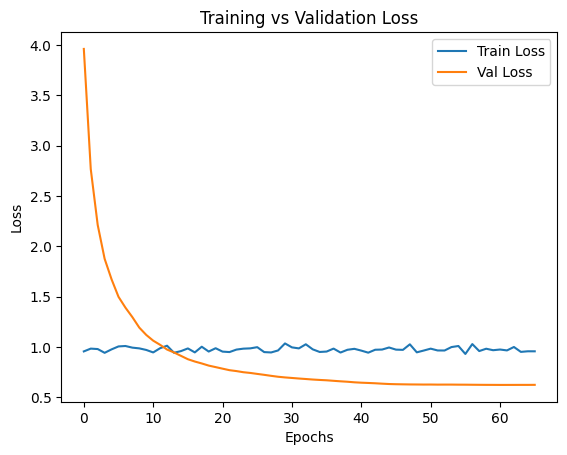

In [9]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [10]:
loss, acc, auc = model.evaluate(X_test, y_test, verbose=2)
print(f'Restored model, accuracy: {100 * acc:5.2f}%')

1/1 - 0s - 42ms/step - AUC: 0.7824 - accuracy: 0.1429 - loss: 0.6222
Restored model, accuracy: 14.29%


In [11]:
# Predict probabilities
y_pred_prob = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


In [12]:
best_thresholds = get_best_thresholds(y_pred_prob, y_test)
best_thresholds


array([0.45, 0.56, 0.62])

In [13]:
# Apply threshold to get binary predictions
y_pred = (y_pred_prob >= best_thresholds).astype(int)

print("CNN:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average="macro"))
print("Recall:", recall_score(y_test, y_pred, average="macro"))
print("F1 Score:", f1_score(y_test, y_pred, average="macro"))

print(classification_report(y_test, y_pred, target_names=labels))

CNN:
Accuracy: 0.5714285714285714
Precision: 0.8666666666666667
Recall: 0.9259259259259259
F1 Score: 0.875
              precision    recall  f1-score   support

        mint       0.60      1.00      0.75         6
        leak       1.00      1.00      1.00         3
       limit       1.00      0.78      0.88         9

   micro avg       0.80      0.89      0.84        18
   macro avg       0.87      0.93      0.88        18
weighted avg       0.87      0.89      0.85        18
 samples avg       0.58      0.61      0.58        18



<Figure size 400x300 with 0 Axes>

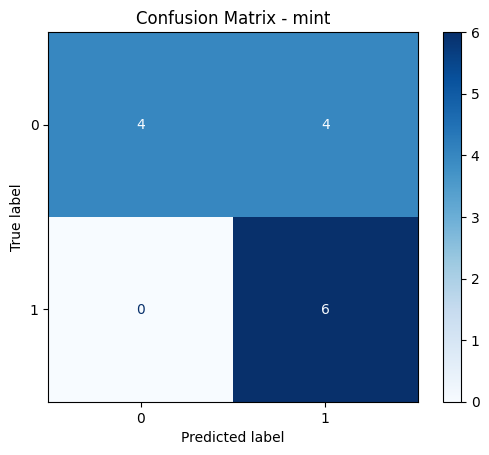

<Figure size 400x300 with 0 Axes>

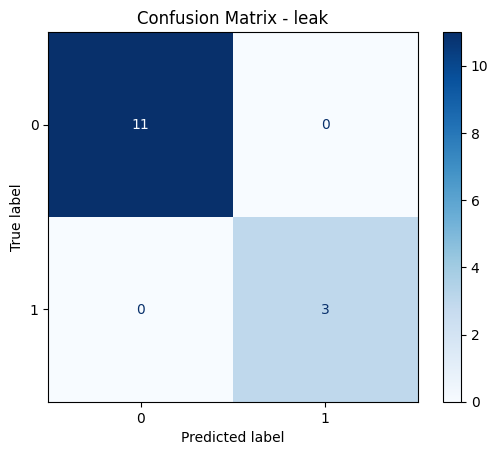

<Figure size 400x300 with 0 Axes>

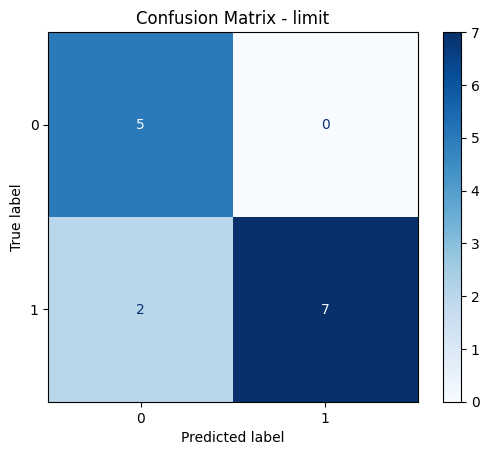

In [14]:
for i, label in enumerate(labels):
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

    plt.figure(figsize=(4, 3))
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix - {label}")
    plt.show()
